In [154]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sb
import sklearn as sk

## Load and Clean Data
The dataset is clean and consistently formatted, but I still perform validation and coercion as a best practice.

In [155]:
# Load CSV
df = pd.read_csv(
    'price_data_multicurrency.csv',
    encoding='utf-8',
    on_bad_lines='skip',
    engine='python'
)

# Standardize column names
df.columns = df.columns.str.strip().str.upper()

# Convert price to numeric
df['PRICE'] = pd.to_numeric(df['PRICE'], errors='coerce')

# Clean currency text
df['CURRENCY'] = df['CURRENCY'].astype(str).str.upper().str.strip()

# Convert timestamp
df['TRADE_TIMESTAMP'] = pd.to_datetime(df['TRADE_TIMESTAMP'], errors='coerce')

# Remove any improper cases
df = df.dropna(subset=['PRICE', 'CURRENCY', 'TRADE_TIMESTAMP'])
df = df[df['CURRENCY'].isin(['EUR', 'AUD', 'USD'])]

# Sort by timestamp
df = df.sort_values('TRADE_TIMESTAMP').reset_index(drop=True)

# Display the cleaned dataset summary
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815 entries, 0 to 814
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TRADE_TIMESTAMP  815 non-null    datetime64[ns]
 1   PRICE            815 non-null    float64       
 2   CURRENCY         815 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 19.2+ KB


## Data Exploration
Currencies have distinct price distributions, volatility profiles, and behavioral patterns. We will explore the dataset to understand the distribution of prices, timestamps, and currency labels. This will help us verify data quality and identify any patterns that will be useful for feature engineering.

In [156]:
df.head()

,TRADE_TIMESTAMP,PRICE,CURRENCY
0,2018-01-02 22:28:01.747,0.0938,EUR
1,2018-01-03 02:17:53.896,0.0876,EUR
2,2018-01-03 09:57:12.584,0.0802,AUD
3,2018-01-03 22:09:31.159,0.0692,EUR
4,2018-01-04 02:22:08.771,0.0675,EUR


In [157]:
df.describe(include='all')

,TRADE_TIMESTAMP,PRICE,CURRENCY
count,815,815.000000,815
unique,NaN,NaN,3
top,NaN,NaN,EUR
freq,NaN,NaN,423
mean,2018-06-06 21:34:12.245659136,0.065127,NaN
min,2018-01-02 22:28:01.747000,0.033000,NaN
25%,2018-03-23 12:28:55.644499968,0.057750,NaN
50%,2018-06-12 22:38:35.164999936,0.064500,NaN
75%,2018-08-19 23:17:07.388000256,0.072700,NaN
max,2018-10-30 22:50:36.370000,0.093800,NaN


In [158]:
df['CURRENCY'].value_counts()

,count
CURRENCY,
EUR,423
AUD,269
USD,123


**Price Distribution by Currency-**

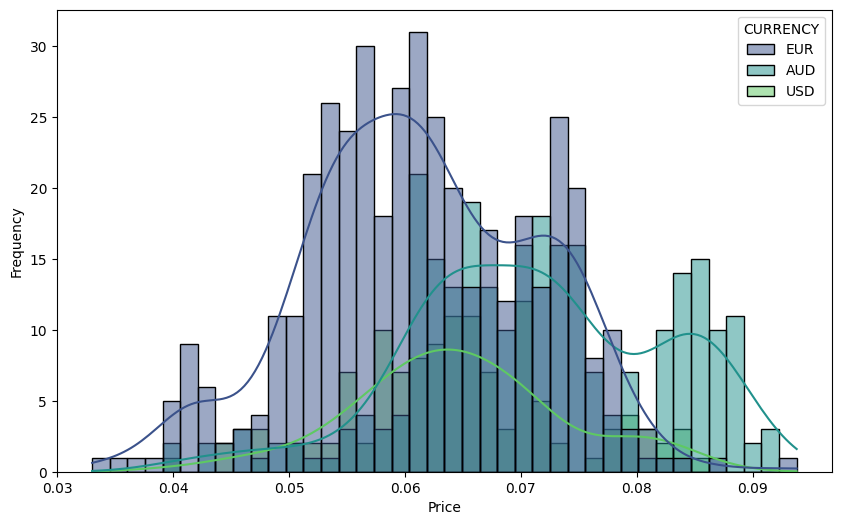

In [159]:
plt.figure(figsize=(10,6))
sb.histplot(data=df, x='PRICE', hue='CURRENCY', kde=True, bins=40, palette='viridis')
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

Clear differences in the central ranges and density shapes:

AUD - highest overall price levels, prices in the 0.08–0.09 range are predominantly AUD

EUR - prices cluster more tightly around 0.055–0.065, highest density of observations

USD - occupies a central band (around 0.06–0.07) but with lower density

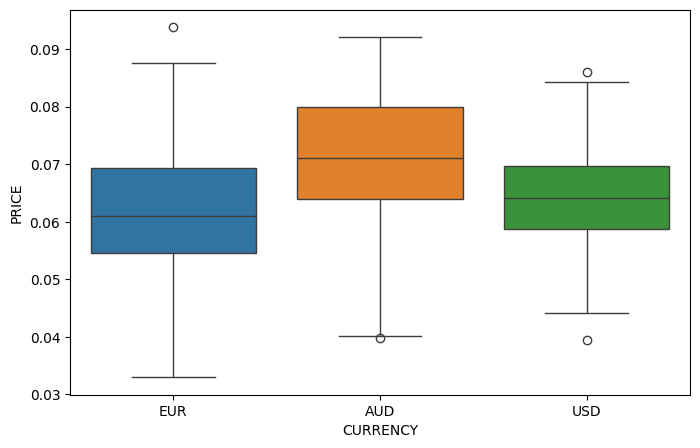

In [160]:
plt.figure(figsize=(8,5))
sb.boxplot(data=df, x='CURRENCY', y='PRICE', hue='CURRENCY')
plt.show()

AUD has the highest median price and the highest upper quartile.

EUR has several noticeable downward outliers.

USD shows a moderate range between EUR and AUD.

**Time-Based Analysis-**

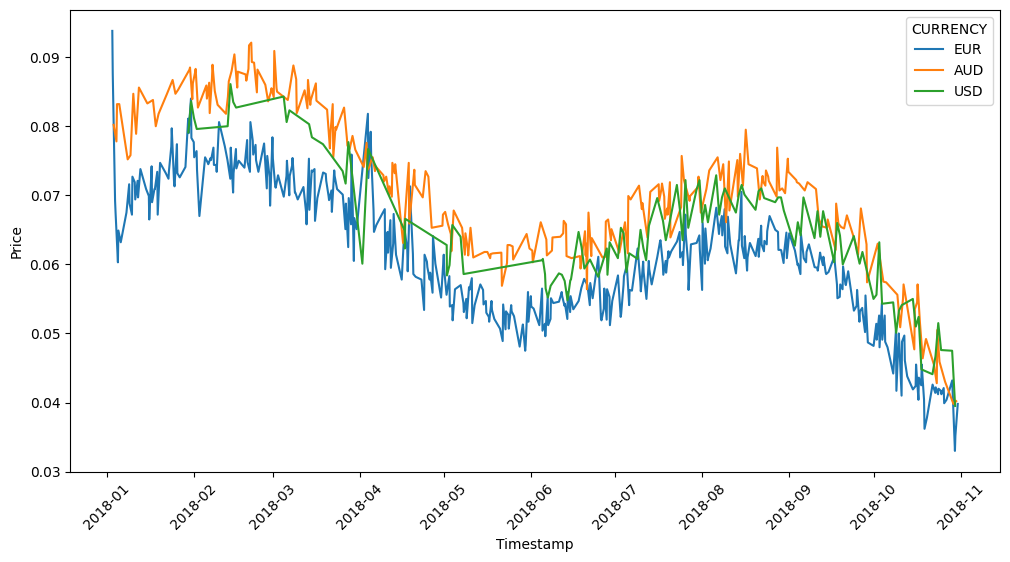

In [161]:
plt.figure(figsize=(12,6))
sb.lineplot(data=df, x='TRADE_TIMESTAMP', y='PRICE', hue='CURRENCY')
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

Although the currencies follow a similar long-term trend, they maintain consistent separation in their price levels over time.

The relative ordering (AUD > USD > EUR) is stable throughout the year.

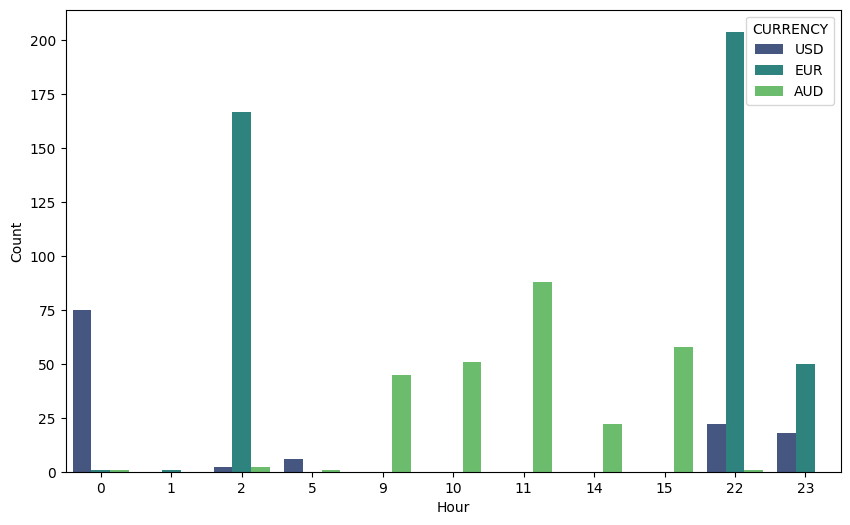

In [162]:
df['HOUR'] = df['TRADE_TIMESTAMP'].dt.hour

plt.figure(figsize=(10,6))
sb.countplot(data=df, x='HOUR', hue='CURRENCY', palette='viridis')
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()


Each currency tends to appear during specific hours of the day.

USD dominates the early-day hour (0)

EUR dominates very early morning (2) and late night (22–23)

AUD dominates mid-day hours (9–15)

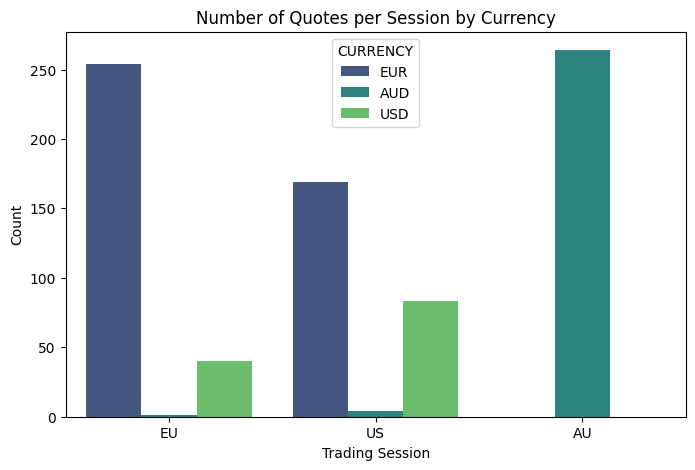

In [163]:
def session_from_hour(h):
    if 0 <= h < 8:
        return 'US'
    elif 8 <= h < 16:
        return 'AU'
    else:
        return 'EU'

df['SESSION'] = df['HOUR'].apply(session_from_hour)

plt.figure(figsize=(8,5))
sb.countplot(x=session_labels, hue=df['CURRENCY'], palette='viridis')
plt.title("Number of Quotes per Session by Currency")
plt.xlabel("Trading Session")
plt.ylabel("Count")
plt.show()

EUR dominates the EU and US sessions

AUD is massively dominant in the AU session

USD appears mainly in the US session with a smaller presence in the EU session.

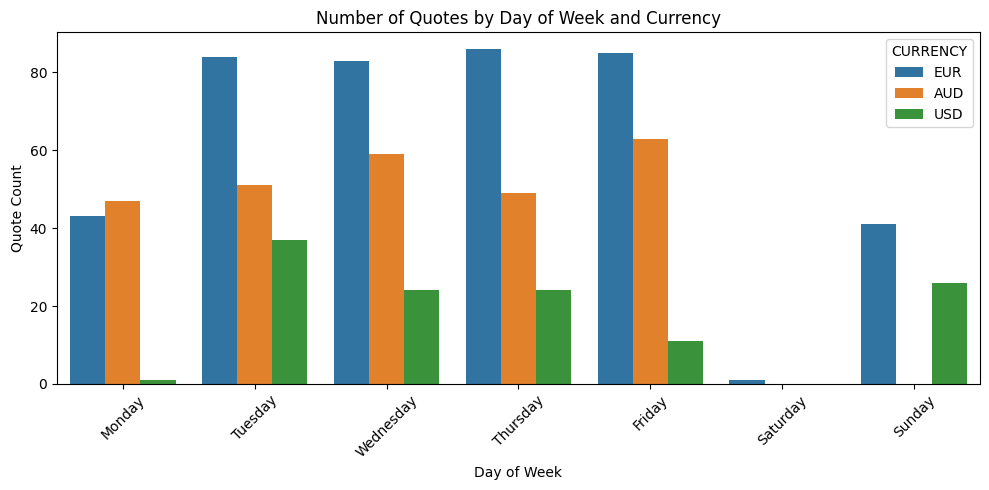

In [164]:
df['DAY_OF_WEEK'] = df['TRADE_TIMESTAMP'].dt.day_name()

plt.figure(figsize=(10,5))
sb.countplot(data=df, x='DAY_OF_WEEK', hue='CURRENCY', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title("Number of Quotes by Day of Week and Currency")
plt.xlabel("Day of Week")
plt.ylabel("Quote Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [165]:
print(df.columns.tolist())
# Remove ALL EDA-created columns
df = df.drop(columns=['HOUR', 'SESSION', 'DAY_OF_WEEK'], errors='ignore')
print(df.columns.tolist())

['TRADE_TIMESTAMP', 'PRICE', 'CURRENCY', 'HOUR', 'SESSION', 'DAY_OF_WEEK']
['TRADE_TIMESTAMP', 'PRICE', 'CURRENCY']


## Model Training-

In [166]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

All feature engineering and normalization use training-only statistics to avoid data leakage.

Splits are chronological (no shuffle, no stratification) to preserve real market behavior.


In [167]:
# Train/Validation/Test Split
# 70% train, 15% val, 15% test
n = len(df)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

train_df = df.iloc[:train_end]
val_df   = df.iloc[train_end:val_end]
test_df  = df.iloc[val_end:]

# Compute Normalization Stats (Training Only)
price_mean = train_df['PRICE'].mean()
price_std  = train_df['PRICE'].std()

# Feature Engineering Function
def add_features(data):
    data = data.copy()
    ts = pd.to_datetime(data['TRADE_TIMESTAMP'])

    data['PRICE_Z'] = (data['PRICE'] - price_mean) / price_std
    data['HOUR'] = ts.dt.hour
    data['DAY_OF_WEEK'] = ts.dt.dayofweek
    data['SESSION_US'] = ((ts.dt.hour >= 0)  & (ts.dt.hour < 8)).astype(int)
    data['SESSION_AU']   = ((ts.dt.hour >= 8)  & (ts.dt.hour < 16)).astype(int)
    data['SESSION_EU']   = ((ts.dt.hour >= 16)).astype(int)

    return data

train_df = add_features(train_df)
val_df   = add_features(val_df)
test_df  = add_features(test_df)

feature_cols = [
    'PRICE', 'PRICE_Z',
    'HOUR', 'DAY_OF_WEEK',
    'SESSION_US', 'SESSION_AU', 'SESSION_EU'
]

# Apply feature engineering to train/val/test
X_train = train_df[feature_cols]
y_train = train_df['CURRENCY']

X_val = val_df[feature_cols]
y_val = val_df['CURRENCY']

X_test = test_df[feature_cols]
y_test = test_df['CURRENCY']


**Hyperparameter Tuning Using Validation Set-**

**Gradient Boosting** is the best model for classifying structured tabular datasets like this one.

In [168]:
results = []

for n_trees in [150, 300, 500]:
    for lr in [0.1, 0.05, 0.02]:
        for depth in [2, 3, 4]:

            m = GradientBoostingClassifier(
                n_estimators=n_trees,
                learning_rate=lr,
                max_depth=depth,
                random_state=42
            )
            m.fit(X_train, y_train)

            preds_val = m.predict(X_val)
            acc_val = accuracy_score(y_val, preds_val)

            results.append((n_trees, lr, depth, acc_val))

tuning_df = pd.DataFrame(
    results,
    columns=['Trees', 'LearningRate', 'Depth', 'ValAccuracy']
)

print("Top 5 Hyperparameter Results:")
print(tuning_df.sort_values('ValAccuracy', ascending=False).head())

Top 5 Hyperparameter Results:
    Trees  LearningRate  Depth  ValAccuracy
0     150          0.10      2     0.991803
7     150          0.02      3     0.991803
3     150          0.05      2     0.991803
21    500          0.05      2     0.991803
16    300          0.02      3     0.991803


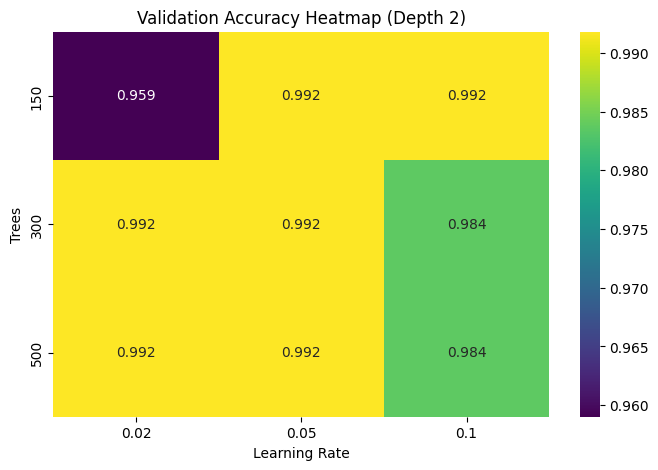

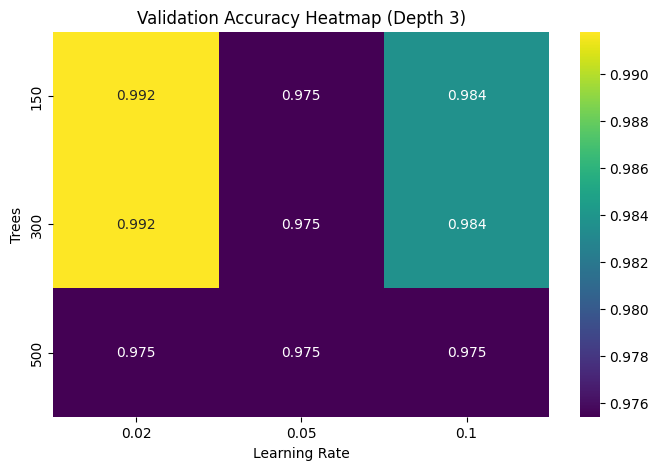

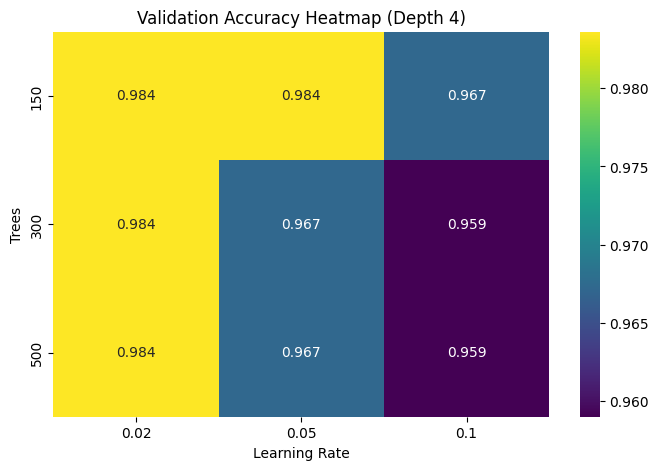

In [169]:
for depth in sorted(tuning_df['Depth'].unique()):
    subset = tuning_df[tuning_df['Depth'] == depth]

    pivot = subset.pivot_table(
        values='ValAccuracy',
        index='Trees',
        columns='LearningRate'
    )

    plt.figure(figsize=(8,5))
    sb.heatmap(pivot, annot=True, cmap='viridis', fmt=".3f")
    plt.title(f"Validation Accuracy Heatmap (Depth {depth})")
    plt.xlabel("Learning Rate")
    plt.ylabel("Trees")
    plt.show()

In [170]:
# Select best hyperparameters
best = tuning_df.sort_values('ValAccuracy', ascending=False).iloc[0]
best_trees = int(best['Trees'])
best_lr    = float(best['LearningRate'])
best_depth = int(best['Depth'])

print(best)

Trees           150.000000
LearningRate      0.100000
Depth             2.000000
ValAccuracy       0.991803
Name: 0, dtype: float64


**Final Model-**

In [171]:
# Train Gradient Boosting Classifier on Train + Validation Sets
# Validation set was used for hyperparameter tuning, now we use it to train the final model.

final_train_df = pd.concat([train_df, val_df], axis=0)
X_final_train = final_train_df[feature_cols]
y_final_train = final_train_df['CURRENCY']

model = GradientBoostingClassifier(
    n_estimators=best_trees,
    learning_rate=best_lr,
    max_depth=best_depth,
    random_state=42
)
model.fit(X_final_train, y_final_train)

GradientBoostingClassifier(max_depth=2, n_estimators=150, random_state=42)

## Model Evaluation Using Test Set-

In [172]:
y_test_pred = model.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


Test Accuracy: 0.967479674796748
              precision    recall  f1-score   support

         AUD       1.00      1.00      1.00        33
         EUR       0.94      1.00      0.97        64
         USD       1.00      0.85      0.92        26

    accuracy                           0.97       123
   macro avg       0.98      0.95      0.96       123
weighted avg       0.97      0.97      0.97       123



**Confusion Matrix-**

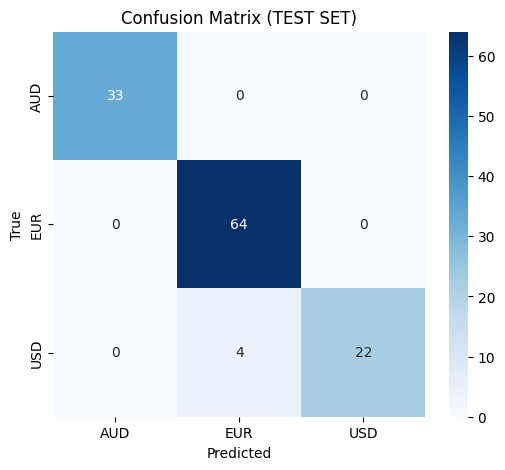

In [173]:
cm = confusion_matrix(y_test, y_test_pred, labels=model.classes_)

plt.figure(figsize=(6,5))
sb.heatmap(cm, annot=True, fmt='d',
            xticklabels=model.classes_,
            yticklabels=model.classes_,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (TEST SET)")
plt.show()

**Probability Confidence-**

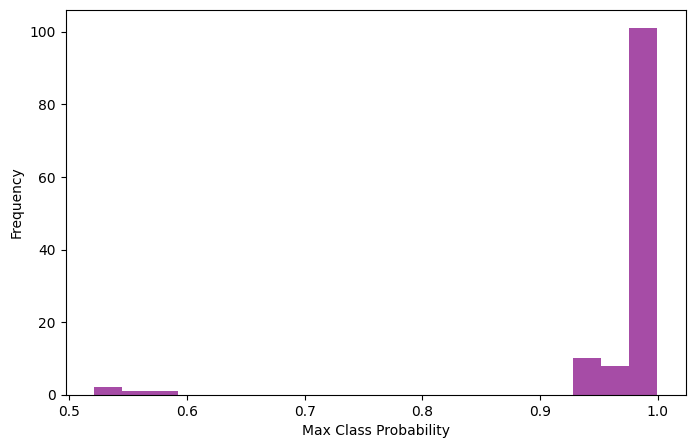

In [174]:
probs = model.predict_proba(X_test).max(axis=1)

plt.figure(figsize=(8,5))
plt.hist(probs, bins=20, color='purple', alpha=0.7)
plt.xlabel("Max Class Probability")
plt.ylabel("Frequency")
plt.show()

**Feature Importance Plot-**

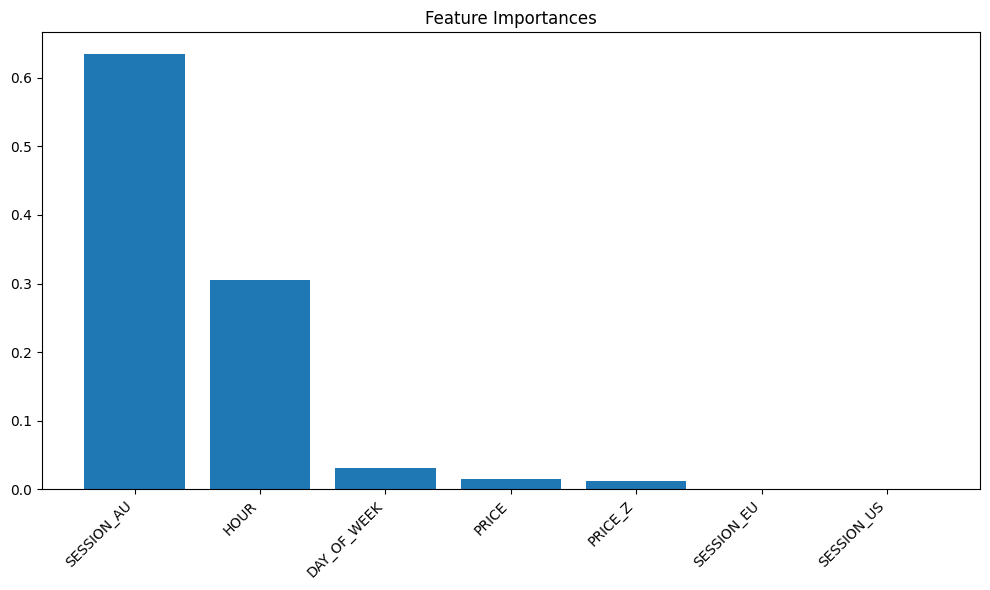

In [175]:
importances = model.feature_importances_
idx = np.argsort(importances)[::-1]
names = [feature_cols[i] for i in idx]

plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[idx])
plt.xticks(range(len(importances)), names, rotation=45, ha='right')
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

## Prediction Function-

In [176]:
# Predict the currency for a new quote based on price and timestamp.
# Returns (predicted_currency, probability).
def predict_currency(price, timestamp):
    ts = pd.to_datetime(timestamp)

    row = {
        'PRICE': price,
        'PRICE_Z': (price - price_mean) / price_std,
        'HOUR': ts.hour,
        'DAY_OF_WEEK': ts.dayofweek,
        'SESSION_US': 1 if 0 <= ts.hour < 8 else 0,
        'SESSION_AU':   1 if 8 <= ts.hour < 16 else 0,
        'SESSION_EU':   1 if ts.hour >= 16 else 0
    }

    row_df = pd.DataFrame([row])[feature_cols]

    probs = model.predict_proba(row_df)[0]
    prediction_index = probs.argmax()
    return model.classes_[prediction_index], float(probs[prediction_index])

**Test Function-**

In [177]:
results = []

for i, row in test_df.iterrows():
    pred_label, prob = predict_currency(row['PRICE'], row['TRADE_TIMESTAMP'])

    results.append({
        'true': row['CURRENCY'],
        'pred': pred_label,
        'prob': prob,
        'price': row['PRICE'],
        'timestamp': row['TRADE_TIMESTAMP']
    })

results_df = pd.DataFrame(results)

custom_acc = (results_df['true'] == results_df['pred']).mean()
print("\nPrediction Function Test Accuracy:", custom_acc)



Prediction Function Test Accuracy: 0.967479674796748


In [178]:
for currency in sorted(results_df['true'].unique()):
    sub = results_df[results_df['true'] == currency]
    print(f"{currency}: { (sub['true'] == sub['pred']).mean():.4f} ({len(sub)} samples)")

AUD: 1.0000 (33 samples)
EUR: 1.0000 (64 samples)
USD: 0.8462 (26 samples)
